In [1]:
# 残差网络
''' 
随着我们设计越来越深的⽹络，深刻理解“新添加的层如何提升神经⽹络的性能”变得⾄关重要。更重要的
是设计⽹络的能⼒，在这种⽹络中，添加层会使⽹络更具表现⼒，为了取得质的突破，我们需要⼀些数学基
础知识。
-------------------------------------------------------------------------------------
函数类

只有当较复杂的函数类包含较⼩的函数类时，我们才能确保提⾼它们的性能。对于深度神经⽹络，如果我们
能将新添加的层训练成恒等映射（identity function）f(x) = x，新模型和原模型将同样有效。同时，
由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这⼀问题，何恺明等⼈提出了残差⽹络（ResNet）[He et al., 2016a]。它在2015年的ImageNet图像识别
挑战赛夺魁，并深刻影响了后来的深度神经⽹络的设计。残差⽹络的核⼼思想是：每个附加层都应该更容易
地包含原始函数作为其元素之⼀。于是，残差块（residual blocks）便诞⽣了，这个设计对如何建⽴深层神
经⽹络产⽣了深远的影响。凭借它，ResNet赢得了2015年ImageNet⼤规模视觉识别挑战赛。
-------------------------------------------------------------------------------------
残差块 VGG,结束了卷积核的战国时代

ResNet沿⽤了VGG完整的3 × 3卷积层设计。残差块⾥⾸先有2个有相同输出通道数的3 × 3卷积层。每个卷积
层后接⼀个批量规范化层和ReLU激活函数。然后我们通过跨层数据通路，跳过这2个卷积运算，将输⼊直接
加在最后的ReLU激活函数前。这样的设计要求2个卷积层的输出与输⼊形状⼀样，从⽽使它们可以相加。如
果想改变通道数，就需要引⼊⼀个额外的1 × 1卷积层来将输⼊变换成需要的形状后再做相加运算。残差块的
实现如下：
'''
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
''' 
我们在定义自已的网络的时候，需要继承nn.Module类，
并重新实现构造函数__init__和forward这两个方法。但有一些注意技巧：

1 一般把网络中具有可学习参数的层（如全连接层、卷积层等）放在构造函数__init__()中，
当然我也可以把不具有参数的层也放在里面；

2 一般把不具有可学习参数的层(如ReLU、dropout、BatchNormanation层)可放在构造函数中，
也可不放在构造函数中，如果不放在构造函数__init__里面，则在forward方法里面可以使用nn.functional来代替
    
3 forward方法是必须要重写的，它是实现模型的功能，实现各个层之间的连接关系的核心。

详见文尾 
'''
class Residual(nn.Module): #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels) # 属性 num_channels 输出通道
        self.bn2 = nn.BatchNorm2d(num_channels)
    def forward(self, X): # 方法
        Y = F.relu(self.bn1(self.conv1(X))) # 卷积 批量规范化 激活
        Y = self.bn2(self.conv2(Y)) # 卷积 批量规范化 后接残差的跳跃连接
        if self.conv3: # 若需改变通道
            X = self.conv3(X) 
        Y += X  # 将输入添加到输出
        return F.relu(Y) # 激活

In [3]:
''' 
此代码⽣成两种类型的⽹络：⼀种是当use_1x1conv=False时，应⽤ReLU⾮线性函数之前，
将输⼊添加到输出。另⼀种是当use_1x1conv=True时，添加通过1 × 1卷积调整通道和分辨率。
'''
# 下⾯我们来查看输⼊和输出形状⼀致的情况。
blk = Residual(3,3) # 输入通道 3  输出通道 3
X = torch.rand(4, 3, 6, 6) # 样本数 通道 高 宽
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# 我们也可以在增加输出通道数的同时，减半输出的⾼和宽。
blk = Residual(3,6, use_1x1conv=True, strides=2) # 输入通道 3 输出通道 6
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
# ResNet模型
''' 
ResNet的前两层跟之前介绍的GoogLeNet中的⼀样：在输出通道数为64、步幅为2的7 × 7卷积层后，接步幅
为2的3 × 3的最⼤汇聚层。不同之处在于ResNet每个卷积层后增加了批量规范化层。
'''
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
''' 
GoogLeNet在后⾯接了4个由Inception块组成的模块。ResNet则使⽤4个由残差块组成的模块，每个模块使⽤
若⼲个同样输出通道数的残差块。第⼀个模块的通道数同输⼊通道数⼀致。由于之前已经使⽤了步幅为2的
最⼤汇聚层，所以⽆须减⼩⾼和宽。之后的每个模块在第⼀个残差块⾥将上⼀个模块的通道数翻倍，并将⾼
和宽减半。
下⾯我们来实现这个模块。注意，我们对第⼀个模块做了特别处理。
'''
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = [] # 块
    for i in range(num_residuals): # 残差块数目
        if i == 0 and not first_block: # 若是模块中的第一个残差块并且不是第一个残差模块
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2)) # 使用1x1卷积改变c并将h,w减半
        else:
            blk.append(Residual(num_channels, num_channels)) # 无需减少 h,w
    return blk

In [7]:
# 接着在ResNet加⼊所有残差模块(4个)，这⾥每个模块使⽤2个残差块
# resnet_block(input_channels, num_channels, num_residuals,first_block=False)
''' 
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
'''
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # 每个模块使用2个残差块
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
# 最后，与GoogLeNet⼀样，在ResNet中加⼊全局平均汇聚层，以及全连接层输出。
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)), # 高 宽
                    nn.Flatten(), nn.Linear(512, 10)) # 将512个通道视为512个特征

In [9]:
''' 
每个模块有4个卷积层（不包括恒等映射的1 × 1卷积层）。加上第⼀个7 × 7卷积层和最后⼀个全连接层，共
有18层。因此，这种模型通常被称为ResNet-18。通过配置不同的通道数和模块⾥的残差块数可以得到不同
的ResNet模型，例如更深的含152层的ResNet-152。虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架
构更简单，修改也更⽅便。这些因素都导致了ResNet迅速被⼴泛使⽤。图7.6.4描述了完整的ResNet-18。

在训练ResNet之前，让我们观察⼀下ResNet中不同模块的输⼊形状是如何变化的。在之前所有架构中，分辨
率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。
'''
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.016, train acc 0.996, test acc 0.911
3103.0 examples/sec on cuda:0


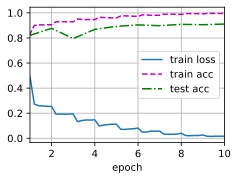

In [10]:
# 训练模型
# 同之前⼀样，我们在Fashion-MNIST数据集上训练ResNet。
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
''' 
⼩结
• 学习嵌套函数（nested function）是训练神经⽹络的理想情况。在深层神经⽹络中，学习另⼀层作为恒
等映射（identity function）较容易（尽管这是⼀个极端情况）。
• 残差映射可以更容易地学习同⼀函数，例如将权重层中的参数近似为零。
• 利⽤残差块（residual blocks）可以训练出⼀个有效的深层神经⽹络：输⼊可以通过层间的残余连接更
快地向前传播。
• 残差⽹络（ResNet）对随后的深层神经⽹络设计产⽣了深远影响。
'''

In [ ]:
# 为什么深度网络（vgg，resnet）最后都不使用softmax（概率归一）函数，而是直接加fc层？
''' 
softmax运算获取⼀个向量并将其映射为概率

尽管softmax是⼀个⾮线性函数，但softmax回归的输出仍然由输⼊特征的仿射变换决定。因此，softmax回
归是⼀个线性模型（linear model

在训练softmax回归模型后，给出任何样本特征，我们可以预测每个输出类别的概率。通常我们使⽤预测概
率最⾼的类别作为输出类别。如果预测与实际类别（标签）⼀致，则预测是正确的。在接下来的实验中，我
们将使⽤精度（accuracy）来评估模型的性能。精度等于正确预测数与预测总数之间的⽐率。

softmax回归是⼀个单层神经⽹络,由于计算每个输出o1、o2和o3取决于所有输⼊x1、x2、x3和x4，
所以softmax回归的输出层也是全连接层。因此，为了实现我们的模型，我们只需在Sequential中
添加⼀个带有10个输出的全连接层
--------------------------------------------------------------------------------------------
深度神经网络的最后一层往往是全连接层+Softmax(分类网络)

全连接层将权重矩阵与输入向量相乘再加上偏置，将n个(−∞,+∞) 的实数映射为
K个(−∞,+∞) 的实数（分数）；Softmax将K个(−∞,+∞) 的实数映射为K 个(0,1)的实数（概率），
同时保证它们之和为1。具体如下：
                y^=softmax(z)=softmax(WT x+b)

通常将网络最后一个全连接层的输入视为网络从输入数据提取到的特征。
通过对特征加权求和得到每个类别的分数，再经过Softmax映射为概率。

softmax回归的输出层是⼀个全连接层。因此，为了实现我们的模型，我们只需
在Sequential中添加⼀个带有10个输出的全连接层。
--------------------------------------------------------------------------------------------
为什么深度网络（vgg，resnet）最后都不使用softmax（概率归一）函数，而是直接加fc层？

这个问题很简单，并不是没有使用softmax，而是没有显式使用softmax。
随着深度学习框架的发展，为了更好的性能，部分框架选择了在使用交叉熵损失函数时默认加上softmax，
这样无论你的输出层是什么，只要用了nn.CrossEntropyLoss就默认加上了softmax。
不仅是Pytorch，国内的飞桨PaddlePaddle2.0等框架也是这样。但在更早的一些版本，
默认是不隐式添加softmax的，所以会有一部分教程/资料，要求在撰写对应代码时手动添加softmax。
当然，自己的框架是否需要手动在输出层添加softmax，推荐看对应的API文档。道听途说不一定可取，
毕竟一个softmax可以做分类，俩softmax搞不好就不收敛了（逃）

RESNET、VGG等网络的网络结构最后一层都是softmax函数。RESNET本质上就是VGG+shortcut。
所以就只针对VGG进行讨论吧。就pytorch框架，VGG的损失函数使用的是nn.CrossEntropyLoss()，
该损失函数结合了nn.LogSoftmax() 和 nn.NLLLoss()两个函数

Pytorch中的nn.CrossEntropyLoss()函数的主要是将softmax-log-NLLLoss合并到一块得到的结果。

    1、Softmax后的数值都在0~1之间，所以ln之后值域是负无穷到0。

    2、然后将Softmax之后的结果取log，将乘法改成加法减少计算量，同时保障函数的单调性 。

    3、NLLLoss的结果就是把上面的输出与Label对应的那个值拿出来去掉负号，再求均值。

总结：并不是VGG网络结构中不含softmax这一层，而是集成到了Loss函数中做运算去了。

Pytorch 网络结构 model.py，最后一层确实不是softmax。 
以分类任务为例，最后一层是 nn.Linear()，
因为 Pytorch 把后续的softmax等操作放到了nn.CrossEntropyLoss() 里面了。

softmax被集成到了交叉熵损失里面，所以在网络最后不需要添加softmax

softmax 和 cross entropy的结合实在太过常用，以至于很多框架在计算loss时都把他们集合在一个函数里了。
但是在测试阶段是会接softmax的

'''

In [ ]:
''' 
torch.nn是专门为神经网络设计的模块化接口。nn构建于autograd之上，可以用来定义和运行神经网络。
nn.Module是nn中十分重要的类,包含网络各层的定义及forward方法。
定义自已的网络：
    需要继承nn.Module类，并实现forward方法。
    
    一般把网络中具有可学习参数的层放在构造函数__init__()中，
    不具有可学习参数的层(如ReLU)可放在构造函数中，也可不放在构造函数中(而在forward中使用nn.functional来代替)
    
    只要在nn.Module的子类中定义了forward函数，backward函数就会被自动实现(利用Autograd)。
    
    在forward函数中可以使用任何Variable支持的函数，毕竟在整个pytorch构建的图中，是Variable在流动。
    还可以使用if,for,print,log等python语法.
    
注：Pytorch基于nn.Module构建的模型中，只支持mini-batch的Variable输入方式

在使用pytorch的时候，模型训练时，不需要使用forward，
只要在实例化一个对象中传入对应的参数就可以自动调用 forward 函数
'''

In [ ]:
''' 
经常写PyTorch模型的人会写：output = model(images)来进行前项传播，
但是有没有仔细想过为啥这个image传入之后就能自动调用forward呢？
---------------------------------------------------------------------------
利用Python的语言特性，y = model(x)是调用了对象model的__call__方法，
而nn.Module把__call__方法实现为类对象的forward函数，
所以任意继承了nn.Module的类对象都可以这样简写来调用forward函数。

调用forward方法的具体流程是：

执行y = model(x)时，由于LeNet类继承了Module类，而Module这个基类中定义了__call__方法，
所以会执行__call__方法，而__call__方法中调用了forward()方法

只要定义类型的时候，实现__call__函数，这个类型就成为可调用的。
换句话说，我们可以把这个类型的对象当作函数来使用

总结：当执行model(x)的时候，底层自动调用forward方法计算结果
'''